In [1]:
import pandas as pd
import pyodbc
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as dt
from sklearn import linear_model
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from flask import Flask, jsonify,request

In [2]:
%config IPCompleter.greedy=True

In [3]:
app = Flask(__name__)

@app.route('/')
def index():
    return "Hello, World!"

In [4]:
@app.route('/api/PredictShelfLife', methods=['POST'])
def PredShelfLife():    
    
    ClassName= request.json.get("ClassName","")
    CategoryName= request.json.get("CategoryName","")
    GroupName=request.json.get("GroupName","")
    ShopCode=request.json.get("ShopCode","")
    Season=request.json.get("Season","")
    SalePrice=request.json.get("SalePrice","")
    ShelfLife=itemShelfLifePrediction(ClassName, CategoryName, GroupName, ShopCode, Season, SalePrice)
    
    
    return jsonify({'ShelfLife': ShelfLife}), 201

In [5]:
@app.route('/api/PredictPrice', methods=['POST'])
def PredPrice():    
    
    ClassName= request.json.get("ClassName","")
    CategoryName= request.json.get("CategoryName","")
    SubClassName= request.json.get("SubClassName","")
    ColorName=request.json.get("ColorName","")
    GroupName=request.json.get("GroupName","")
    TypeName=request.json.get("TypeName","")
    Season=request.json.get("Season","")
    
    Price=itemPricePrediction(ClassName, CategoryName, SubClassName,ColorName, GroupName, TypeName,Season)
    
    
    return jsonify({'Price': Price}), 201

In [6]:
# query = "select items.ItemCode, DesignCode,category.CategoryName,class.ClassName,subclass.SubClassName,items.ItemName,units.UnitName,size.SizeName,color.ColorName,sources.SourceName,vendors.VendorName,groups.GroupName,types.TypeName,items.SalePrice from tblSetup_Items as items inner join tblSetup_ItemsCategories as category on items.CategoryCode = category.CategoryCode inner join tblSetup_ItemsClasses as class on items.ClassCode = class.ClassCode inner join tblSetup_ItemsClassesSub as subclass on items.SubClassCode = subclass.SubClassCode inner join tblSetup_ItemsUnits as units on items.UnitCode = units.UnitCode inner join tblSetup_ItemsSizes as size on items.SizeCode = size.SizeCode inner join tblSetup_ItemsColors as color on items.ColorCode = color.ColorCode inner join tblSetup_Sources as sources on items.Source = sources.SourceCode inner join tblSetup_Vendors as vendors on items.VendorCode = vendors.VendorCode inner join tblSetup_ItemsGroups as groups on items.GroupCode = groups.GroupCode inner join tblSetup_ItemsTypes as types on items.TypeCode = types.TypeCode"
query = "select * from shopWiseShelfLife"
queryDFS = "SELECT distinct [ItemCode],[VoucherDate] FROM [AliFashion].[dbo].[ReceiveAtShopDenorm] order by ItemCode"


In [7]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=DESKTOP-2BUG72N;DATABASE=AliFashion;Trusted_Connection=yes') 
df = pd.read_sql(query, sql_conn)
dfs = pd.read_sql(queryDFS, sql_conn)

In [8]:
pf = dfs
pf['month'] = pd.DatetimeIndex(pf['VoucherDate']).month
pf["Season"] = np.where(pf["month"]>3, '1','0')
pf["Season2"] = np.where(pf["month"]<10, '1','0') 
pf["SaleSeason"] = np.where(pf["Season"] == pf["Season2"], 'Summer','Winter')

pf = pf.drop("month",axis=1)
pf = pf.drop("Season",axis=1)
pf = pf.drop("Season2",axis=1)

pf['freq'] = pf.groupby('ItemCode')['ItemCode'].transform('count')

In [9]:
newDF = pd.DataFrame(columns=["ItemCode", "Season"])

for item in pf.ItemCode.unique():
    indexes = pf.ItemCode == item
    temp = pf[indexes]
    flags = temp.SaleSeason.str.contains('Winter', case=True, regex=True).value_counts()
    if flags.size < 2:
        newDF = newDF.append({"ItemCode":item, "Season":flags.keys()[0]},ignore_index=True)
    else:
        if flags[0] > flags[1]:
            newDF = newDF.append({"ItemCode":item, "Season":flags.keys()[0]},ignore_index=True)
        else:
            newDF = newDF.append({"ItemCode":item, "Season":flags.keys()[1]},ignore_index=True)

newDF.Season = newDF.Season.astype(str)
newDF.ItemCode = newDF.ItemCode.astype('int64')

newDF.Season[newDF.Season == 'True'] = "Winter"
newDF.Season[newDF.Season == 'False'] = "Summer"

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
df = df.dropna()
train = df
trainData = df


train["Season"] = pd.Series()
for item, season in zip(newDF.ItemCode, newDF.Season):
        mask = train.ItemCode == item
        column_name = 'Season'
        train.loc[mask, column_name] = season
        

In [11]:
# train = train.dropna()
# trainData = trainData.dropna()

train['ClassNameEncoded'] = train['ClassName']
train['SubClassNameEncoded'] = train['SubClassName']
train['ItemNameEncoded'] = train['ItemName']
train['TypeNameEncoded'] = train['TypeName']
train['CategoryNameEncoded'] = train['CategoryName']
train['CategoryNameEncoded'] = train['CategoryName']
train['ColorNameEncoded'] = train['ColorName']
train['GroupNameEncoded'] = train['GroupName']
train['SeasonEncoded'] = train['Season']

counter = 0
for className in train.ClassName.unique():
    train['ClassNameEncoded'] = train.apply(lambda x: counter if x['ClassNameEncoded'] == className else x['ClassNameEncoded'], axis=1)
    counter = counter + 1 
    
counter = 0
for className in train.SubClassName.unique():
    train['SubClassNameEncoded'] = train.apply(lambda x: counter if x['SubClassNameEncoded'] == className else x['SubClassNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for item in train.ItemName.unique():
    train['ItemNameEncoded'] = train.apply(lambda x: counter if x['ItemNameEncoded'] == item else x['ItemNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for typeN in train.TypeName.unique():
    train['TypeNameEncoded'] = train.apply(lambda x: counter if x['TypeNameEncoded'] == typeN else x['TypeNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for category in train.CategoryName.unique():
    train['CategoryNameEncoded'] = train.apply(lambda x: counter if x['CategoryNameEncoded'] == category else x['CategoryNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for color in train.ColorName.unique():
    train['ColorNameEncoded'] = train.apply(lambda x: counter if x['ColorNameEncoded'] == color else x['ColorNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for group in train.GroupName.unique():
    train['GroupNameEncoded'] = train.apply(lambda x: counter if x['GroupNameEncoded'] == group else x['GroupNameEncoded'], axis=1)
    counter = counter + 1 

counter = 0
for group in train.Season.unique():
    train['SeasonEncoded'] = train.apply(lambda x: counter if x['SeasonEncoded'] == group else x['SeasonEncoded'], axis=1)
    counter = counter + 1 

In [12]:
train

,ShopCode,shlefLife,ItemCode,DesignCode,CategoryName,ClassName,SubClassName,ItemName,UnitName,SizeName,...,SalePrice,Season,ClassNameEncoded,SubClassNameEncoded,ItemNameEncoded,TypeNameEncoded,CategoryNameEncoded,ColorNameEncoded,GroupNameEncoded,SeasonEncoded
0,3.0,0.087324,1,X3296,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Bombo Dupatta,Bombo Slub + Bombo Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,0,0,0,0,0,0,0
1,3.0,0.200000,2,X2595,Suit 03 Piece,Swiss Lawn,Swiss Lawn Shirt + Chiffon Dupatta,Swiss Lawn + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,2632.0,Winter,1,1,1,0,0,0,0,0
3,3.0,0.055556,4,X2574,Suit 03 Piece,Swiss Lawn,Swiss Lawn Shirt + Chiffon Dupatta,Swiss Lawn + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,2632.0,Winter,1,1,1,0,0,0,0,0
4,3.0,0.027778,5,X2939,Suit 03 Piece,Swiss Lawn,Swiss Lawn Shirt + Chiffon Dupatta,Swiss Lawn + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,2632.0,Winter,1,1,1,0,0,0,0,0
7,3.0,0.407080,8,PLAIN,Suit 03 Piece,Swiss Lawn,Swiss Lawn Shirt + Chiffon Dupatta,Swiss Lawn + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,2632.0,Winter,1,1,1,0,0,0,0,0
15,3.0,0.013514,16,X3294,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Chiffon Dupatta,Bombo Slub + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,2,2,0,0,0,0,0
16,2.0,0.142857,16,X3294,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Chiffon Dupatta,Bombo Slub + Chiffon Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,2,2,0,0,0,0,0
17,3.0,0.069333,17,X3297,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Bombo Dupatta,Bombo Slub + Bombo Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,0,3,0,0,0,0,0
19,3.0,0.008230,19,X3275,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Bombo Dupatta,Bombo Slub + Bombo Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,0,3,0,0,0,0,0
20,3.0,0.022727,20,X3266,Suit 03 Piece,Bombo Slub,Bombo Slub Shirt + Bombo Dupatta,Bombo Slub + Bombo Dupatta 3 Piece Suit,PCS,Standard,...,1920.0,Winter,0,0,3,0,0,0,0,0


In [13]:
def correlation( attribute_1, attribute_2 ):
    """
    Implement the function correlation that takes as input 2 numeric variables and calculates correlation between them.
    Use Pearson Correlation - The one which you studied in class
    Do not use built in libraries
    """
    meanA = np.mean(attribute_1)
    meanB = np.mean(attribute_2)
    
    stdA = np.std(attribute_1)
    stdB = np.std(attribute_2)
    
    const = len(train) * meanA * meanB
    sum = 0
    for a,b in zip(attribute_1, attribute_2):
        sum = sum + ((a*b) - const)
    
    divisor = ((len(train) -1)* stdA * stdB)
    corr = 0
    if divisor != 0:
        corr = sum / divisor
    
    return corr



In [14]:
train.describe()

,ShopCode,shlefLife,ItemCode,SalePrice,ClassNameEncoded,SubClassNameEncoded,ItemNameEncoded,TypeNameEncoded,CategoryNameEncoded,ColorNameEncoded,GroupNameEncoded,SeasonEncoded
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,2.498920,0.247573,1224.772354,1855.528294,15.278186,51.718790,186.562419,0.930022,2.192657,0.123110,0.115335,0.523542
std,0.513747,0.690210,691.663976,1166.015140,12.904557,37.897943,92.201528,0.255166,2.763673,0.328635,0.319495,0.499553
min,2.000000,0.000000,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.029412,611.500000,1040.000000,6.000000,20.000000,143.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.085106,1228.000000,1800.000000,10.000000,52.000000,166.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.213039,1860.500000,2632.000000,21.000000,65.000000,258.000000,1.000000,3.000000,0.000000,0.000000,1.000000
max,4.000000,11.900000,2397.000000,10080.000000,56.000000,160.000000,399.000000,1.000000,15.000000,1.000000,1.000000,1.000000


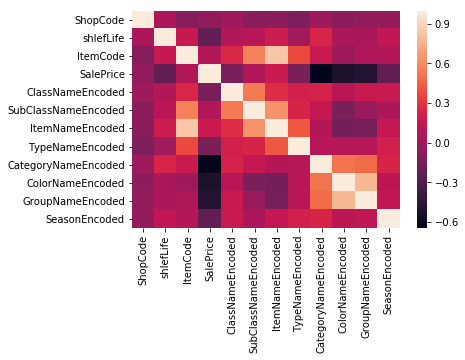

In [15]:
corr = train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [16]:
colNames = train[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded', 'ColorNameEncoded', 'GroupNameEncoded','TypeNameEncoded','ShopCode', 'SeasonEncoded']]
corrDict = {}
for col in colNames.columns:
    corrDict[col] = (correlation(train[col], train.SalePrice))
    
corrDict = (sorted(corrDict.items(), key=lambda kv: kv[1], reverse= 1))
corrDict

[('GroupNameEncoded', -1330.9367893227916),
 ('ColorNameEncoded', -1381.1674599909884),
 ('CategoryNameEncoded', -2924.7028943715914),
 ('SeasonEncoded', -3862.7560802561534),
 ('ClassNameEncoded', -4363.592502557872),
 ('SubClassNameEncoded', -5029.53573931745),
 ('TypeNameEncoded', -13433.118063980326),
 ('ShopCode', -17926.94611840598)]

In [17]:
trainData = train.sample(frac=0.8)
y_trainSales = trainData['SalePrice']
x_trainSales = trainData[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded',
                     'ColorNameEncoded', 'GroupNameEncoded', 'TypeNameEncoded','SeasonEncoded']]

testData = train.sample(frac=0.2)
y_testSales = testData['SalePrice']
x_testSales = testData[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded',
                   'ColorNameEncoded', 'GroupNameEncoded', 'TypeNameEncoded', 'SeasonEncoded']]

decClf = RandomForestClassifier(n_estimators=100, max_depth=20,
                             random_state=0)
decClf.fit(x_trainSales,y_trainSales)

# print("On random training data,  score is:",decClf.score(x_train,y_train))
### Testing Accuracy = ???
print("Random Forest Classifier score:",decClf.score(x_testSales,y_testSales))
### The score varies due the training set being random

Random Forest Classifier score: 0.8682505399568035


In [18]:
reg = LinearRegression().fit(x_trainSales, y_trainSales)
y_predictedSales = reg.predict(x_testSales)
rms = sqrt(mean_squared_error(y_testSales, y_predictedSales))

print("RMSE For Linear Regression:" ,rms)

RMSE For Linear Regression: 825.0990819389741


In [19]:
# regr_1 = linear_model.Ridge(alpha=.5)
regr_1 = RandomForestRegressor(max_depth=25, random_state=0,
                              n_estimators=100)

regr_2Sales = DecisionTreeRegressor(max_depth=20)
regr_1.fit(x_trainSales, y_trainSales)
regr_2Sales.fit(x_trainSales, y_trainSales)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

y_1 = regr_1.predict(x_testSales)
y_2Sales = regr_2Sales.predict(x_testSales)

rms1 = sqrt(mean_squared_error(y_testSales, y_1))
rms2 = sqrt(mean_squared_error(y_testSales, y_2Sales))
print("RMSE For Random Forest Regression:" ,rms1)
print("RMSE For Decision Tree Regression:" ,rms2)

RMSE For Random Forest Regression: 206.1752700905291
RMSE For Decision Tree Regression: 197.48663210391675


In [20]:
def trainAndMakePredictionReady_ItemPrice():
    trainData = train.sample(frac=0.8)
    y_trainSales = trainData['SalePrice']
    x_trainSales = trainData[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded',
                         'ColorNameEncoded', 'GroupNameEncoded', 'TypeNameEncoded','SeasonEncoded']]

    testData = train.sample(frac=0.2)
    y_testSales = testData['SalePrice']
    x_testSales = testData[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded',
                       'ColorNameEncoded', 'GroupNameEncoded', 'TypeNameEncoded', 'SeasonEncoded']]

    regr_2Sales = DecisionTreeRegressor(max_depth=20)
    regr_2Sales.fit(x_trainSales, y_trainSales)

    RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=0, verbose=0, warm_start=False)
    return regr_2Sales

In [21]:
def itemPricePrediction(ClassName, CategoryName, SubClassName,ColorName, GroupName, TypeName,Season):
    print("---------------------------------")
    print(Season)
    ClassNameEncoded = train.loc[train['ClassName'] == ClassName].ClassNameEncoded.unique()[0]
    CategoryNameEncoded = train.loc[train['CategoryName'] == CategoryName].CategoryNameEncoded.unique()[0]
    SubClassNameEncoded = train.loc[train['SubClassName'] == SubClassName].SubClassNameEncoded.unique()[0]
    ColorNameEncoded = train.loc[train['ColorName'] == ColorName].ColorNameEncoded.unique()[0]
    GroupNameEncoded = train.loc[train['GroupName'] == GroupName].GroupNameEncoded.unique()[0]
    TypeNameEncoded = train.loc[train['TypeName'] == TypeName].TypeNameEncoded.unique()[0]
    SeasonEncoded = train.loc[train['Season'] == Season].SeasonEncoded.unique()[0]
    
    Sales = trainAndMakePredictionReady_ItemPrice().predict([[ClassNameEncoded, CategoryNameEncoded, SubClassNameEncoded,
                     ColorNameEncoded, GroupNameEncoded, TypeNameEncoded,SeasonEncoded]])
    return Sales[0]
itemPricePrediction("Swiss Lawn",'Suit 03 Piece', 'Bombo Slub Shirt + Bombo Dupatta', 'Multi-Color', 'Ladies Fabric', 'Fancy', 'Winter' )

---------------------------------
Winter


2632.0

In [22]:
colNames = train[['ClassNameEncoded', 'CategoryNameEncoded', 'SubClassNameEncoded','ColorNameEncoded',
                  'GroupNameEncoded', 'TypeNameEncoded','ShopCode', 'SeasonEncoded', 'SalePrice']]
corrDict = {}
for col in colNames.columns:
    corrDict[col] = (correlation(train[col], train.shlefLife))
    
corrDict = (sorted(corrDict.items(), key=lambda kv: kv[1], reverse= 1))
corrDict

[('GroupNameEncoded', -299.84364035701475),
 ('ColorNameEncoded', -311.1461985910116),
 ('CategoryNameEncoded', -658.8493836993512),
 ('SeasonEncoded', -870.490215778091),
 ('ClassNameEncoded', -983.4553318093098),
 ('SubClassNameEncoded', -1133.586285826131),
 ('SalePrice', -1322.2006289043802),
 ('TypeNameEncoded', -3027.81949868617),
 ('ShopCode', -4040.713429031384)]

[]

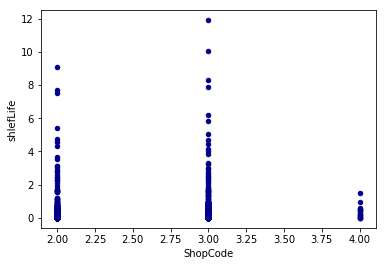

In [23]:
ax1 = df.plot.scatter(x='ShopCode',
                       y='shlefLife',
                       c='DarkBlue')

ax1.plot()

In [24]:
trainData = train.sample(frac=0.80)
y_trainShelfLife = trainData['shlefLife']
x_trainShelfLife = trainData[['ClassNameEncoded', 'CategoryNameEncoded',  'GroupNameEncoded', 
                     'ShopCode','SeasonEncoded', 'SalePrice']]

testData = train.sample(frac=0.20)
y_testShelfLife = testData['shlefLife']
x_testShelfLife = testData[['ClassNameEncoded', 'CategoryNameEncoded',  'GroupNameEncoded',
                   'ShopCode','SeasonEncoded', 'SalePrice']]

In [25]:
reg = LinearRegression().fit(x_trainShelfLife, y_trainShelfLife)
y_predictedShelfLife = reg.predict(x_testShelfLife)
rms = sqrt(mean_squared_error(y_testShelfLife, y_predictedShelfLife))

print("RMSE For Linear Regression:" ,rms)


RMSE For Linear Regression: 0.4792012829965125


In [26]:
# regr_1 = linear_model.Ridge(alpha=.5)
regr_1 = RandomForestRegressor(max_depth=25, random_state=0,
                              n_estimators=100)

regr_2ShelfLife = DecisionTreeRegressor(max_depth=20)
regr_1.fit(x_trainShelfLife, y_trainShelfLife)
regr_2ShelfLife.fit(x_trainShelfLife, y_trainShelfLife)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
# print(regr_1.feature_importances_)
# print(regr_2.feature_importances_)

y_1 = regr_1.predict(x_testShelfLife)
y_2ShelfLife = regr_2ShelfLife.predict(x_testShelfLife)

rms1 = sqrt(mean_squared_error(y_testShelfLife, y_1))
rms2 = sqrt(mean_squared_error(y_testShelfLife, y_2ShelfLife))
print("RMSE For Random Forest Regression:" ,rms1)
print("RMSE For Decision Tree Regression:" ,rms2)

RMSE For Random Forest Regression: 0.2848486628218718
RMSE For Decision Tree Regression: 0.2683883096787264


In [27]:
def trainAndMakePredictionReady_ShelfLife():
    trainData = train.sample(frac=0.80)
    y_trainShelfLife = trainData['shlefLife']
    x_trainShelfLife = trainData[['ClassNameEncoded', 'CategoryNameEncoded',  'GroupNameEncoded', 
                         'ShopCode','SeasonEncoded', 'SalePrice']]

    testData = train.sample(frac=0.20)
    y_testShelfLife = testData['shlefLife']
    x_testShelfLife = testData[['ClassNameEncoded', 'CategoryNameEncoded',  'GroupNameEncoded',
                       'ShopCode','SeasonEncoded', 'SalePrice']]
    regr_2ShelfLife = DecisionTreeRegressor(max_depth=20)
    regr_2ShelfLife.fit(x_trainShelfLife, y_trainShelfLife)

    RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=0, verbose=0, warm_start=False)
    
    return regr_2ShelfLife

In [28]:
def itemShelfLifePrediction(ClassName, CategoryName, GroupName, ShopCode, Season, SalePrice):
    ClassNameEncoded = train.loc[train['ClassName'] == ClassName].ClassNameEncoded.unique()[0]
    CategoryNameEncoded = train.loc[train['CategoryName'] == CategoryName].CategoryNameEncoded.unique()[0]
#     SubClassNameEncoded = train.loc[train['SubClassName'] == SubClassName].SubClassNameEncoded.unique()[0]
#     ColorNameEncoded = train.loc[train['ColorName'] == ColorName].ColorNameEncoded.unique()[0]
    GroupNameEncoded = train.loc[train['GroupName'] == GroupName].GroupNameEncoded.unique()[0]
#     TypeNameEncoded = train.loc[train['TypeName'] == TypeName].TypeNameEncoded.unique()[0]
    SeasonEncoded = train.loc[train['Season'] == Season].SeasonEncoded.unique()[0]
    
    ShelfLife = trainAndMakePredictionReady_ShelfLife().predict([[ClassNameEncoded, CategoryNameEncoded,
                           GroupNameEncoded, ShopCode ,SeasonEncoded, SalePrice]])
    return ShelfLife[0]
itemShelfLifePrediction("Swiss Lawn",'Suit 03 Piece', 'Ladies Fabric', 3, 'Winter', 1920 )

0.027056636191749323

In [29]:
query = "SELECT top 1000 tblTrans_ReceiveAtShopDetail.ShopCode,tblTrans_ReceiveAtShopDetail.StoreCode,[VoucherNoRef],[VoucherLineNoRef],tblTrans_ReceiveAtShopDetail.VoucherNo,[VoucherLineNo],[ItemCode],[DesignCode],[UnitCode],[SizeCode],[ColorCode],[SalePrice],[QtyDis],[Qty],[SourceCode],[VendorCode],VoucherDate,Remarks FROM [AliFashion].[dbo].[tblTrans_ReceiveAtShopDetail]inner join tblTrans_ReceiveAtShopHead on tblTrans_ReceiveAtShopDetail.VoucherNo=tblTrans_ReceiveAtShopHead.VoucherNo and tblTrans_ReceiveAtShopDetail.ShopCode=tblTrans_ReceiveAtShopHead.ShopCode"

In [30]:
df1 = pd.read_sql(query, sql_conn)

df1.head(100)

,ShopCode,StoreCode,VoucherNoRef,VoucherLineNoRef,VoucherNo,VoucherLineNo,ItemCode,DesignCode,UnitCode,SizeCode,ColorCode,SalePrice,QtyDis,Qty,SourceCode,VendorCode,VoucherDate,Remarks
0,2,1,17,0001,1,0001,274,X2978,1,1,1,3070.0,12.00,12.00,1,1,2017-03-03,
1,2,1,17,0002,1,0002,275,X2979,1,1,1,3070.0,12.00,12.00,1,1,2017-03-03,
2,2,1,17,0003,1,0003,276,X2981,1,1,1,3070.0,12.00,12.00,1,1,2017-03-03,
3,2,1,17,0004,1,0004,277,X3127,1,1,1,3070.0,10.00,10.00,1,1,2017-03-03,
4,2,1,17,0005,1,0005,278,X2991,1,1,1,3070.0,12.00,12.00,1,1,2017-03-03,
5,2,1,17,0006,1,0006,279,X2986,1,1,1,3070.0,12.00,12.00,1,1,2017-03-03,
6,2,1,17,0007,1,0007,280,X2134,1,1,1,2380.0,10.00,10.00,1,1,2017-03-03,
7,2,1,17,0008,1,0008,281,X2133,1,1,1,2380.0,12.00,12.00,1,1,2017-03-03,
8,2,1,17,0009,1,0009,282,X2138,1,1,1,2380.0,12.00,12.00,1,1,2017-03-03,
9,2,1,18,0001,2,0001,205,SPX3850D,1,1,1,3600.0,6.00,6.00,1,1,2017-03-03,


In [31]:
query = "SELECT tblTrans_SaleInvoiceDetail.RefVoucherNo,[RefVoucherLineNo],[StoreCode],tblTrans_SaleInvoiceDetail.VoucherNo,[VoucherLineNo],[ItemCode],[DesignCode],[UnitCode],[SizeCode],[ColorCode],[SalePrice],[Qty],[QtyCleared],[xQty],[QtyDiscount],[GrossAmount],[DiscountPer],[NetAmount],[GlobalDiscount],[TotalNetAmount],[ReceiptTotalCash],[ReceiptTotalCredit],[Change],tblTrans_SaleInvoiceDetail.ShopCode,[SourceCode],[VendorCode],VoucherDate FROM [AliFashion].[dbo].[tblTrans_SaleInvoiceDetail] inner join tblTrans_SaleInvoiceHead on tblTrans_SaleInvoiceDetail.VoucherNo=tblTrans_SaleInvoiceHead.VoucherNo and tblTrans_SaleInvoiceDetail.ShopCode=tblTrans_SaleInvoiceHead.ShopCode"

In [32]:
df2 = pd.read_sql(query, sql_conn)

df2.head(100)

,RefVoucherNo,RefVoucherLineNo,StoreCode,VoucherNo,VoucherLineNo,ItemCode,DesignCode,UnitCode,SizeCode,ColorCode,...,NetAmount,GlobalDiscount,TotalNetAmount,ReceiptTotalCash,ReceiptTotalCredit,Change,ShopCode,SourceCode,VendorCode,VoucherDate
0,0.0,,1,1,0001,463,X3682,1,1,1,...,2380.00,0.0,2380.00,2400.0,0.0,20.00,2,1,1,2017-03-07
1,0.0,,1,2,0001,63,PLAIN,1,1,1,...,9255.00,0.0,9255.00,9300.0,0.0,45.00,2,1,1,2017-03-07
2,0.0,,1,3,0001,469,X1788,1,1,1,...,2150.00,0.0,2150.00,2500.0,0.0,350.00,2,1,1,2017-03-07
3,0.0,,1,4,0001,63,PLAIN,1,1,1,...,3085.00,0.0,3085.00,3100.0,0.0,15.00,2,1,1,2017-03-07
4,0.0,,1,5,0001,326,X3403,1,1,1,...,3290.00,0.0,3290.00,3500.0,0.0,210.00,2,1,1,2017-03-07
5,0.0,,1,6,0001,448,X3620,1,1,1,...,2380.00,0.0,2978.00,3000.0,0.0,22.00,2,1,1,2017-03-07
6,0.0,,1,6,0002,291,X1845,2,1,2,...,598.00,0.0,2978.00,3000.0,0.0,22.00,2,1,1,2017-03-07
7,0.0,,1,7,0001,332,X3411,1,1,1,...,3290.00,0.0,3290.00,5000.0,0.0,1710.00,2,1,1,2017-03-07
8,0.0,,1,8,0001,465,X1786,1,1,1,...,1935.00,0.0,1935.00,2000.0,0.0,65.00,2,1,1,2017-03-08
9,0.0,,1,9,0001,469,X1788,1,1,1,...,1935.00,0.0,1935.00,2000.0,0.0,65.00,2,1,1,2017-03-08


In [33]:
writer = pd.ExcelWriter('season.xlsx', engine='xlsxwriter')
newDF.to_excel(writer, sheet_name='Sheet1')
writer.save()

In [34]:
if __name__ == '__main__':
     app.run(debug=False)

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/May/2019 18:00:06] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:17] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:19] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:20] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:21] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:22] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:23] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:23] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:24] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:25] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:26] "POST /api/PredictShelfLife HTTP/1.1" 201 -
127.0.0.1 - - [19/May/2019 18:00:27] "POST /api/P

---------------------------------
Winter
